In [36]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

# Define the Vision Transfomer

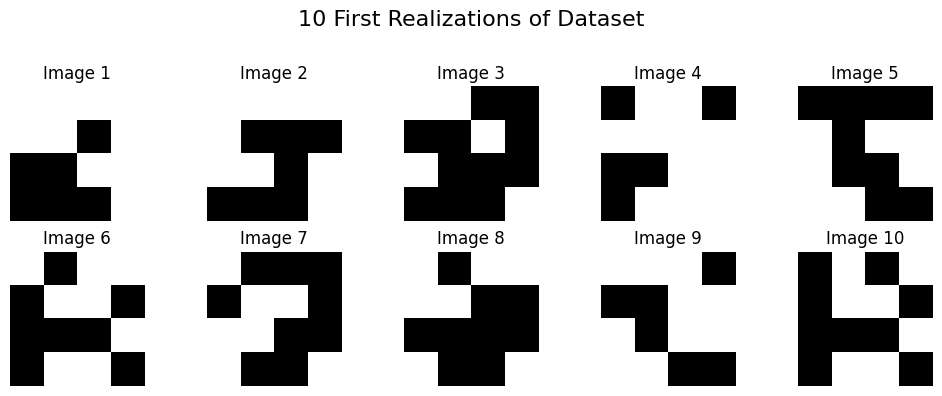

In [80]:
import torch
import torch.nn as nn

class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout=0.0, hidden_dim=None):
        super().__init__()

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

        # Load hidden_dim
        self.hidden_dim = hidden_dim

        # Linear layer to project input embeddings
        self.input_proj = nn.Linear(embed_dim, self.hidden_dim)

        # Positional embeddings
        self.positional_embedding = nn.Parameter(torch.randn(max_patches, 1, self.hidden_dim))  # Shape: (seq_len, 1, hidden_dim)

        # Output layer
        self.fc_out = nn.Linear(self.hidden_dim, num_tokens-1)

    def forward(self, patches):

        # Prepare input for transformer layers
        x = patches.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)

        # Extract seq_len and batch_size
        seq_len, batch_size, _ = x.size()

        # Project input to hidden_dim
        z = self.input_proj(x)  # Shape: (seq_len, batch_size, hidden_dim)

        # Add positional embedding
        pos_emb = self.positional_embedding[:seq_len, :, :].expand(-1, batch_size, -1)  # Shape: (seq_len, batch_size, hidden_dim)
        z = z + pos_emb

        # Pass through transformer layers
        for layer in self.encoder_layers:
            z = layer(z)

        # Output logits
        z = z.permute(1, 0, 2)  # Back to (batch_size, seq_len, hidden_dim)
        logits = self.fc_out(z)  # (batch_size, seq_len, num_tokens-1)
        return logits

    def get_probabilities(self, logits):
        """Compute probabilities using softmax."""
        return torch.softmax(logits, dim=-1)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, feedforward_dim, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Ensure hidden_dim is divisible by num_heads
        assert self.hidden_dim % self.num_heads == 0, "Hidden dimension must be divisible by the number of heads."

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim=self.hidden_dim, num_heads=num_heads, dropout=dropout)

        # Feedforward network
        self.feedforward = nn.Sequential(
            nn.Linear(self.hidden_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, self.hidden_dim),
            nn.Dropout(dropout),
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(self.hidden_dim)
        self.norm2 = nn.LayerNorm(self.hidden_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, z):
        """
        Args:
            z: Tensor of shape (seq_len, batch_size, hidden_dim)
        Returns:
            Tensor of shape (seq_len, batch_size, hidden_dim)
        """
        seq_len, batch_size, hidden_dim = z.size()

        # Apply LayerNorm
        z_norm = self.norm1(z)

        # Self-attention
        attn_output, _ = self.attention(z_norm, z_norm, z_norm)  # Shape: (seq_len, batch_size, hidden_dim)

        # Residual connection
        z = z + self.dropout(attn_output)

        # Feedforward layer
        z_norm = self.norm2(z)
        feedforward_output = self.feedforward(z_norm)

        # Final residual connection
        z = z + self.dropout(feedforward_output)

        return z

import matplotlib.pyplot as plt
# Toy Dataset: 100 Binary 4x4 Images
images = torch.randint(0, 2, (100, 4, 4)).long()

# Plot the first 10 images in a 5x2 subplot
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle("10 First Realizations of Dataset", fontsize=16)

for idx, ax in enumerate(axs.flat):  # Flatten the 2D array of axes for easy iteration
    ax.imshow(images[idx].numpy(), cmap="gray")
    ax.set_title(f"Image {idx + 1}")
    ax.axis("off")  # Turn off the axes for cleaner visualization

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

import wandb
# Parameters
batch_size = 1
embed_dim = 2
hidden_dim = 3
num_heads = 1
feedforward_dim = hidden_dim*2  # (2-4)
num_layers = 1
num_tokens = 5  # 4 tokens + 1 mask token
max_patches = 8
dropout = 0.2
learning_rate = 3e-4
num_epochs = 1

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout, hidden_dim).to(device)
#model.load_state_dict(checkpoint)  # Load model weights
# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#Dataloader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class BinaryImageDataset(Dataset):
    def __init__(self, images):
        """
        Args:
            images (Tensor): Tensor of shape (num_images, 64, 64) with binary values (0 or 1).
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return torch.tensor(image, dtype=torch.float32)

dataset = BinaryImageDataset(images)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def preprocess_image_with_indices(image):
    """
    Splits a 4x4 binary image into flattened 2-cell patches.
    Returns patch indices tensor (num_patches,).
    """
    patches = image.unfold(1, 2, 2).reshape(-1, 2)  # (num_patches, 2)
    patch_indices = (patches * torch.tensor([2, 1])).sum(dim=1)  # Binary to decimal

    return patch_indices

def indices_to_patches_batched(patch_indices):
    """
    Converts batched patch indices back to 2-cell patches.
    Includes the masked patch [0.5, 0.5] for index 4.

    Args:
        patch_indices (torch.Tensor): Tensor of shape (batch_size, num_patches).

    Returns:
        patches (torch.Tensor): Tensor of shape (batch_size, num_patches, 2).
    """
    # Define the index-to-patch mapping
    index_to_patch = {
        0: torch.tensor([0.0, 0.0]),
        1: torch.tensor([0.0, 1.0]),
        2: torch.tensor([1.0, 0.0]),
        3: torch.tensor([1.0, 1.0]),
        4: torch.tensor([0.5, 0.5])  # Masked patch
    }

    # Map each index in the batch to its corresponding patch
    patches = torch.stack([
        torch.stack([index_to_patch[idx.item()] for idx in batch])
        for batch in patch_indices
    ])

    return patches

def create_valid_mask(masked_patches, mask_prob=0.5):
    """
    Creates a mask with at least one `True` and one `False` per batch.

    Args:
        masked_patches (torch.Tensor): Tensor of shape (batch_size, num_patches).
        mask_prob (float): Probability of masking each patch.

    Returns:
        torch.Tensor: Binary mask of the same shape as `masked_patches`.
    """
    # Initial random mask
    mask = torch.rand(masked_patches.shape) < mask_prob  # (batch_size, num_patches)

    # Ensure at least one `True` and one `False` per batch
    for i in range(mask.shape[0]):  # Iterate over batches
        if not mask[i].any():  # If all values are `False`
            mask[i, torch.randint(0, mask.shape[1], (1,))] = True  # Set one random patch to `True`
        if mask[i].all():  # If all values are `True`
            mask[i, torch.randint(0, mask.shape[1], (1,))] = False  # Set one random patch to `False`

    return mask

def image_from_indices_batched(patch_indices, image_shape=(4, 4)):
    """
    Reconstructs binary images from batched patch indices.

    Args:
        patch_indices (torch.Tensor): Tensor of shape (batch_size, num_patches).
        image_shape (tuple): Shape of each reconstructed image (default is 4x4).

    Returns:
        torch.Tensor: Reconstructed binary images of shape (batch_size, *image_shape).
    """
    batch_size, num_patches = patch_indices.shape
    num_rows, num_cols = image_shape
    assert num_rows % 2 == 0 and num_cols % 2 == 0, "Image dimensions must be divisible by 2."

    # Number of patches in each dimension
    patch_rows = num_rows // 2
    patch_cols = num_cols // 2
    assert num_patches == patch_rows * patch_cols, "Number of patches does not match image size."

    # Convert indices back to patches
    patches = torch.stack([
        ((patch_indices >> 1) & 1),  # Extract the first bit (most significant)
        (patch_indices & 1)         # Extract the second bit (least significant)
    ], dim=-1).to(torch.float32)  # Shape: (batch_size, num_patches, 2)

    # Reshape patches into grid
    patches = patches.view(batch_size, patch_rows, patch_cols, 2)  # Shape: (batch_size, patch_rows, patch_cols, 2)

    # Create the full image by placing patches into rows
    image = torch.zeros(batch_size, num_rows, num_cols, dtype=torch.float32)
    for i in range(patch_rows):
        for j in range(patch_cols):
            image[:, i, j * 2:j * 2 + 2] = patches[:, i, j]

    return image

# Training loop

In [81]:
batch_idx,images = next(enumerate(dataloader))
# Preprocess images
Y = torch.stack([preprocess_image_with_indices(img) for img in images]).long() #(batch_size,num_patches,)
print("Y (Original Image):", Y)
print("Y shape:",Y.size())
masked_patches = Y.clone() #(batch_size,num_patches,)

# Masking
masky = torch.zeros(batch_size, max_patches)
mask = create_valid_mask(masky,mask_prob=0.5) #(batch_size,num_patches,)
print("mask:",mask)
print("mask shape:",mask.size())
masked_patches[mask] = num_tokens - 1
print("masked_patches (Masked Image):",masked_patches)
print("masked_patches shape:",masked_patches.size())
X = indices_to_patches_batched(masked_patches) #(batch_size,num_patches,patch_size)
print("X (Patches):",X)
print("X shape:",X.size())
X = X.to(device)
Y = Y.to(device)


# Define weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Forward pass
logits = model(X) #(batch_size,num_patches,num_tokens-1)
probabilities = model.get_probabilities(logits) #(batch_size,num_patches,num_tokens-1)
print("probabilities:",probabilities)
print("probabilities shape:",probabilities.size())
masked_probs = probabilities[mask] #(num_masked_patches,num_tokens-1)
print("Masked probabilities:", masked_probs)
print("Masked probabilities shape:",masked_probs.size())
masked_Y = Y[mask] #(num_masked_patches,)
print("Masked Y:", masked_Y)
print("Masked Y shape:",masked_Y.size())
loss = criterion(masked_probs, masked_Y)
print("loss:",loss)
predicted_indices = torch.argmax(masked_probs, dim=-1)
print("predicted_indices:",predicted_indices)
print("predicted_indices shape:",predicted_indices.size())
reconstructed = Y.clone()#(batch_size,num_patches,patch_size)
reconstructed[mask] = predicted_indices
print("reconstructed:",reconstructed)
print("reconstructed shape:",reconstructed.size())
# Reconstruct images
reconstructed_image = image_from_indices_batched(reconstructed, image_shape=(4, 4))
masked_image = image_from_indices_batched(masked_patches, image_shape=(4, 4))
print("reconstructed_image:", reconstructed_image)
print("reconstructed_image shape:", reconstructed_image.size())
print("masked_image:", masked_image)
print("masked_image shape:", masked_image.size())
fig, axs = plt.subplots(3, figsize=(15, 5))
axs[0].imshow(images[-1].squeeze(), cmap="gray")
axs[0].set_title(f"Original Image")
axs[0].axis("off")
axs[1].imshow(masked_image[-1].squeeze(), cmap="gray")
axs[1].set_title(f"Masked Image")
axs[1].axis("off")
axs[2].imshow(reconstructed_image[-1].squeeze(), cmap="gray")
axs[2].set_title(f"Reconstructed Image")
axs[2].axis("off")
plt.show()
#reconstructed_image = reconstruct_ima_from_patches(predicted_indices)

#visualized_masked_patches = masked_patches.cpu()[0].clone()
#visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
#masked_image = reconstruct_image_from_patches(visualized_masked_patches)



Y (Original Image): tensor([[1, 2, 1, 3, 3, 3, 0, 3]])
Y shape: torch.Size([1, 8])
mask: tensor([[ True,  True, False,  True, False,  True, False,  True]])
mask shape: torch.Size([1, 8])
masked_patches (Masked Image): tensor([[4, 4, 1, 4, 3, 4, 0, 4]])
masked_patches shape: torch.Size([1, 8])
X (Patches): tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.0000, 1.0000],
         [0.5000, 0.5000],
         [1.0000, 1.0000],
         [0.5000, 0.5000],
         [0.0000, 0.0000],
         [0.5000, 0.5000]]])
X shape: torch.Size([1, 8, 2])
probabilities: tensor([[[0.1831, 0.6900, 0.0166, 0.1104],
         [0.3578, 0.0579, 0.0854, 0.4989],
         [0.1478, 0.2815, 0.3785, 0.1922],
         [0.2596, 0.1772, 0.2306, 0.3326],
         [0.0654, 0.0196, 0.6907, 0.2244],
         [0.3567, 0.1084, 0.0756, 0.4593],
         [0.2241, 0.0306, 0.2106, 0.5347],
         [0.2805, 0.3343, 0.0971, 0.2880]]], grad_fn=<SoftmaxBackward0>)
probabilities shape: torch.Size([1, 8, 4])
Masked proba

<ipython-input-80-6bf4a18c6f09>:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32)


AssertionError: Number of patches does not match image size.

In [44]:
# Initialize wandb
wandb.login()
wandb.init(
    project="vision-transformer-toy-example",
    config={
        "batch_size": batch_size,
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "feedforward_dim": feedforward_dim,
        "num_layers": num_layers,
        "num_tokens": num_tokens,
        "max_patches": max_patches,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
    },
)


# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    current_mask_rate = 0.5

    for batch_idx, images in enumerate(dataloader):
        # Preprocess images
        Y = torch.stack([preprocess_image_with_indices(img) for img in images]).long() #(batch_size,num_patches,)
        X = Y.clone() #(batch_size,num_patches,)

        # Masking
        mask = torch.rand(X.shape) < 0.5 #(batch_size,num_patches,)
        X[mask] = num_tokens - 1
        X = indices_to_patches_batched(X) #(batch_size,num_patches,patch_size)
        X = X.to(device)
        Y = Y.to(device)


        # Define weighted CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()

        # Forward pass
        logits = model(X) #(batch_size,num_patches,num_tokens-1)
        probabilities = model.get_probabilities(logits) #(batch_size,num_patches,num_tokens-1)

        masked_probs = probabilities[mask] #(num_masked_patches,num_tokens-1)

        masked_Y = Y[mask] #(num_masked_patches,)

        loss = criterion(masked_probs, masked_Y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log batch metrics
        wandb.log({"batch_loss": loss.item()})

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

        # Log epoch metrics
        wandb.log({"epoch_loss": avg_loss})

        # Add the 5 visualization steps here.....
        with torch.no_grad():
          predicted_indices = torch.argmax(logits, dim=-1).cpu()[0]
          reconstructed_image = reconstruct_image_from_patches(predicted_indices)

          visualized_masked_patches = masked_patches.cpu()[0].clone()
          visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
          masked_image = reconstruct_image_from_patches(visualized_masked_patches)

          # Log visualizations to wandb
          wandb.log({
              "Original Image": wandb.Image(
                  reconstruct_image_from_patches(patch_indices.cpu()[0])
              ),
              "Masked Image": wandb.Image(masked_image, caption="Masked Image"),
              "Reconstructed Image": wandb.Image(
                  reconstructed_image, caption="Reconstructed Image"
              ),
          })

# Save the final model
torch.save(model.state_dict(), "vision_transformer_final_balanced.pth")
wandb.save("vision_transformer_final_balanced.pth")
print("Final model saved as 'vision_transformer_final_balanced.pth'.")
wandb.finish()

<ipython-input-43-2fd9fe305da3>:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32)


Epoch [1/1] completed. Average Loss: 0.0143
Epoch [1/1] completed. Average Loss: 0.0286
Epoch [1/1] completed. Average Loss: 0.0430
Epoch [1/1] completed. Average Loss: 0.0569
Epoch [1/1] completed. Average Loss: 0.0708
Epoch [1/1] completed. Average Loss: 0.0843
Epoch [1/1] completed. Average Loss: 0.0982
Epoch [1/1] completed. Average Loss: 0.1127
Epoch [1/1] completed. Average Loss: 0.1266
Epoch [1/1] completed. Average Loss: 0.1416
Epoch [1/1] completed. Average Loss: 0.1561
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. Average Loss: nan
Epoch [1/1] completed. A

batch_loss,▄▁▄▆▂▃▂▇▂▁▅▂▂▂▂▂▆▃▂▁▄▃▃▄█▄▃▄▂▂▅▄▃▄▃▄▂▅▁▄
epoch_loss,▁▃▅▆█
batch_loss,1.40133
epoch_loss,nan
